# GENDER CLASSIFICATION USING A SPIDER WEB METHOD


### Progetto di Fondamenti di Visione Artificiale e Biometria
### Anno Accademico 2019-2020
##### Salvatore Froncillo      0522500858
##### Pasqualino Gravina		0522500864



###### Repository GitHub: https://github.com/gravina-froncillo/progetto-fvab

-------------------------------------------------------------------------------

## Presentazione del progetto

La gender classification è una tipologia di classificazione ampiamente utilizzata, in particolare viene utilizzata per supportare diverse biometrie di riconoscimento. Tale tipo di classificazione risulta essere molto utile, ad esempio, in ambito forense l’identificazione del genere di un soggetto mediante biometria può restringere il campo di ricerca circa del 50%. 

Una delle biometrie più utilizzate è il volto; quando si analizza il genere dal volto si opera con una biometria fisica.

La struttura ossea di individui di genere maschile o femminile risulta essere differente e bisogna, tuttavia, tener conto che spesso il volto può essere alterato con tratti tipici della popolazione del sesso opposto a quello del soggetto (make-up, barba ecc...).


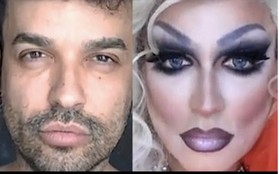

Una tecnica che potrebbe ovviare a problemi di «texture» che spesso si riscontrano in algoritmi di gender recognition, può essere l’utilizzo di landmark. I landmark sono infatti punti «chiave» del volto, generalmente 68, e dopo il loro rilevamento permettono di tralasciare dettagli del volto che in alcuni casi potrebbero essere fuorvianti.

Per studiare la distribuzione dei landmark sui volti si può far riferimento alla codifica di un algoritmo di pose estimation.  L’algoritmo in questione utilizza un modello a ragnatela per suddividere il volto in diversi settori, all’interno dei quali ricadono i landmark.

Il numero di settori della ragnatela è fissa per ogni volto, indipendentemente dalla dimensione del volto; il settore di appartenenza di ogni landmark viene stabilito mediante semplici formule relative alle coordinate cartesiane e alle circonferenze. In figura abbiamo un esempio in cui possiamo notare in verde i 68 landmark del viso e in rosso la ragnatela.


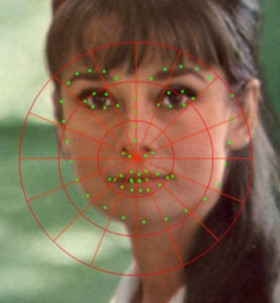

La ragnatela così ottenuta viene «srotolata» divenendo un vettore di interi i cui valori rappresentano il numero di landmark presenti in quel settore. Tale rappresentazione è molto compatta: se si vuole considerare come esempio una ragnatela composta da 4 settori per quadrante e 4 anelli si avrà un array di 64 elementi. 

Questo algoritmo ha inoltre prodotto ottimi risultati nella stima della posa di un soggetto; lo scopo di tale progetto è di testarne l’efficacia applbicandolo ad un problema di gender classification.


## Obiettivi

Al fine di ottenere la classificazione di genere si utilizza il dataset di immagini UTKFace. Tale obiettivo può essere raggiunto mediante utilizzo dei soli dati provenienti dall’algoritmo che applica la ragnatela ai volti presenti nell’immagine. Questo processo si divide in:

•	estrazione del volto dall’immagine;

•	stima della posizione dei landmarks del volto;

•	creazione dell’array che rappresenta la ragnatela mediante l’algoritmo fornito;

•	allenare un classificatore sugli array derivanti dall’algoritmo per la creazione della ragnatela;

•	stimare l’accuratezza raggiunta per la gender classification.


Tale progetto ha coinvolto 2 candidati, pertanto è stato richiesto di:


•	ottenere il dataset assegnato;

•	estrarre dal dataset i volti dei soggetti;

•	individuare la posizione dei landmark;

•	utilizzare più configurazioni della ragnatela per creare diversi training set, validation set e test set

•	creare due classificatori binari per determinare il genere, testandolo con i vari set sopra descritti;

•	valutare le accuratezze relative alle differenti combinazioni e valutarne i pro e i contro.


## Dataset utilizzato

Il dataset UTKFace è un set di dati su volti in larga scala con intervallo di età tra 0 e 116 anni. Il dataset comprende oltre 20.000 immagini di volti etichettati con età, sesso ed etnia. Le immagini coprono grandi variazioni di posa, espressione facciale, illuminazione, risoluzione, ecc. 
Le etichette riferite al volto contenuto in ogni immagine sono incluse nel nome del file e seguono tutte lo stesso schema, ovvero:

[età]_[sesso]_[razza]_[data&ora].jpg

•	[età] è un numero intero compreso tra 0 e 116 e indica l'età

•	[sesso] è 0 (maschio) o 1 (femmina)

•	[razza] è un numero intero compreso tra 0 e 4, che indica bianco, nero, asiatico, indiano e altri (come ispanico, latino, mediorientale)

•	[data&ora] è nel formato di yyyymmddHHMMSSFFF, che mostra la data e l'ora in cui un'immagine è stata inserita all’interno del dataset

Il dataset è fornito in due versioni differenti; la prima definita In-the-wild ovvero contenete l’immagine in formato integrale che comprende anche l’eventuale presenza di altri oggetti ed una seconda versione in cui le immagini contengono solo il volto allineato e ritagliato, tale procedimento è stato effettuato con Dlib. 

Per perseguire lo scopo di tale progetto è stato utilizzata la seconda versione non avendo a disposizione ingenti risorse di calcolo.
Durante la fase di pre-processing è stata analizzata la distribuzione del dataset in base alle features indicate in etichetta per valutare quali potessero essere utili agli obiettivi prefissati; nella pagina seguente sono riportati grafici di tale analisi.

##### Codice per analisi

In [ ]:
import numpy as np
import pandas as pd
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

dataset_folder_name = 'Dataset/utkface/image'
dataset_dict = {
    'razza_id': {
        0: 'bianchi',
        1: 'neri',
        2: 'asiatici',
        3: 'indiani',
        4: 'altri'
    },
    'sesso_id': {
        0: 'Maschi',
        1: 'Femmine'
    }
}

def parse_dataset(dataset_path, ext='jpg'):
    def parse_info_from_file(path):
        try:
            filename = os.path.split(path)[1]
            filename = os.path.splitext(filename)[0]
            eta, sesso, razza, _ = filename.split('_')

            return int(eta), dataset_dict['sesso_id'][int(sesso)], dataset_dict['razza_id'][int(razza)]
        except Exception as ex:
            return None, None, None

    files = glob.glob(os.path.join(dataset_path, "*.%s" % ext))

    records = []
    for file in files:
        info = parse_info_from_file(file)
        records.append(info)

    df = pd.DataFrame(records)
    df['file'] = files
    df.columns = ['Età', 'Sesso', 'Razza', 'file']
    df = df.dropna()
    return df

dataset_dict['sesso_alias'] = dict((g, i) for i, g in dataset_dict['sesso_id'].items())
dataset_dict['razza_alias'] = dict((r, i) for i, r in dataset_dict['razza_id'].items())

df = parse_dataset('Dataset/utkface/image')
df.head()
print(df)

def plot_distribution(pd_series):
    labels = pd_series.value_counts().index.tolist()
    counts = pd_series.value_counts().values.tolist()
    pie_plot = go.Pie(labels=labels, values=counts, hole=.3)
    fig = go.Figure(data=[pie_plot])
    fig.update_layout(title_text='Distribuzione per %s' % pd_series.name)
    fig.show()

#plot_distribution(df['Sesso'])
#plot_distribution(df['Razza'])

coppie = [0, 10, 20, 30, 40, 60, 80, np.inf]
nomi = ['<10', '10-20', '20-30', '30-40', '40-60', '60-80', '80+']
intervalli_eta = pd.cut(df['Età'], coppie, labels=nomi)

plot_distribution(intervalli_eta)


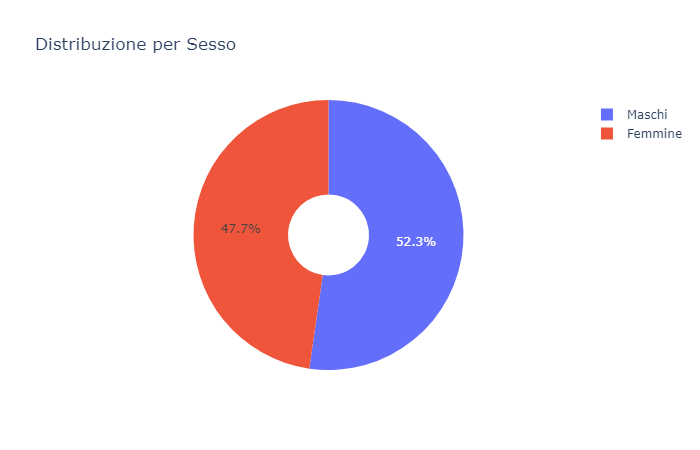

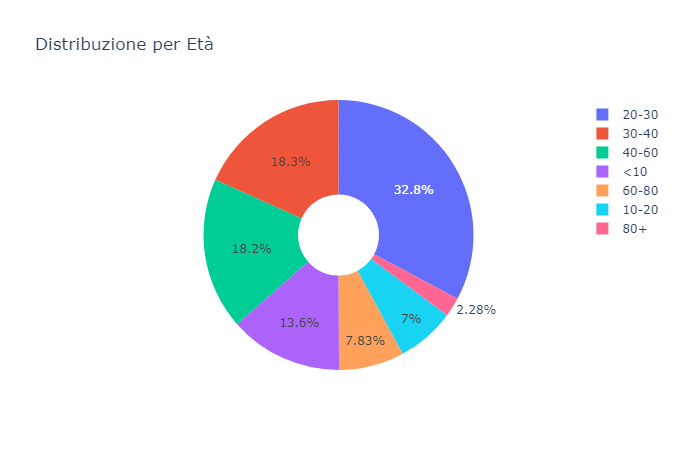

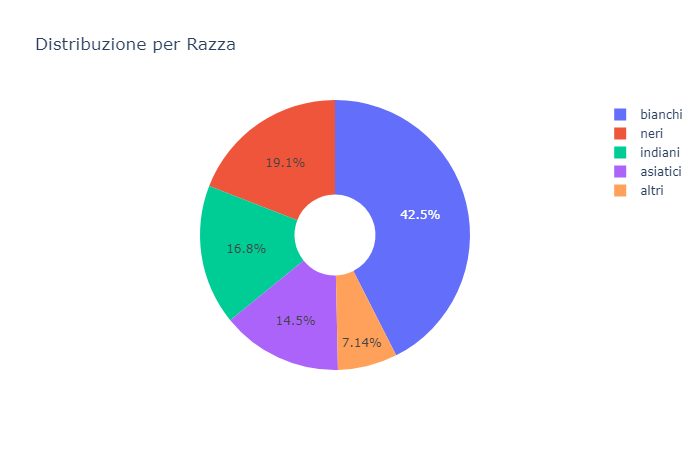

## Configurazioni assegnate

Le quattro configurazioni assegnate sono quelle con MAE (Minor Absolute Error) minore per la pose estimation, e sono le seguenti: 

1.	4C_4S_var2
2.	4C_4S_var4
3.	4C_3S_inv
4.	5C_4S_inv

Il parametro C indica il numero di anelli di cui è composta la ragnatela e il parametro S il numero di settori per ogni quadrante.
Per quanto concerne la differenza tra la prima e la seconda configurazione, vi è una variazione del raggio dal centro della ragnatela ai cerchi. 

| Configurazione| Divisione raggio              | Settori    |
|:---------------|:-------------------------------|:------------|
|   4C_4S_var4  | 4/10*R; 7/10*R; 9/10*R; R     | 64         |
|   4C_4S_var2  | 8/15*R; 12/15*R; 14/15*R; R   | 64         |
|   5C_4S_inv   | R/5; 2/5*R; 3/5*R; 4/5*R; R   | 80         |
|   4C_3S_inv   | R/4; R/2; 3/4*R; R            | 48         |


# Preprocessing

## Algoritmo Ragnatela

All’inizio del progetto è stato fornito un algoritmo basato sulla configurazione 4 settori 4 cerchi per estrarre un “array ragnatela” a partire da un’immagine.

L'algoritmo è diviso in:

•	face detection dell’immagine;

•	estrazione dei 68 landmark del volto;

•	assegnazione di ogni landmark al settore della ragnatela corrispondente.

L'algoritmo assegnato si è rivelato essere una buona base di partenza per la costruzione di una soluzione responsive dell’algoritmo ragnatela, data l’assegnazione per l’utilizzo con diverse configurazioni della ragnatela, tuttavia, sono state necessarie diverse modifiche.


## Algoritmo Ragnatela 2.0

### Configurazioni Responsive

La prima modifica apportata è stata l’aggiunta della funzione scelta (), che permette di scegliere da linea di comando quale configurazione della ragnatela applicare al dataset.

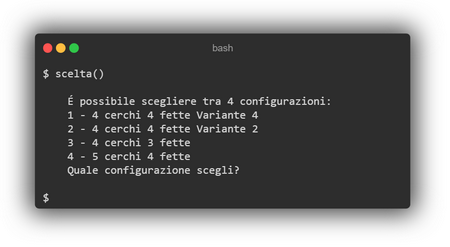

Per rendere totalmente responsive l’algoritmo è stato opportuno modificare in parte anche la funzione preesistente aggiungi().

### Responsive Resize

Nell’algoritmo originale viene effettuato il resize delle immagini ad un numero fisso, pari 512 pixel.

Nella versione di seguito illustrata, tale operazione è stata resa responsive, poiché con numero fisso non è stato possibile individuare i landmark su tutte le immagini. Inoltre, si è notato che abbassando la definizione a 256 pixel l’algoritmo è più veloce e non perde molta accuratezza. 

Per usufruire di tutte le immagini “utilizzabili” si è scelto di aumentare gradualmente la risoluzione delle immagini ogni qualvolta non era possibile, ad una data risoluzione partendo da 256 pixel, riconoscere un volto. 

Dopo vari test è emerso che le immagini che sono impossibili da processare ad una definizione di 2048 pixel, non sono utilizzabili, per tale motivo si è deciso di porre come limite proprio 2048 pixel. 

In definitiva la funzione responsive_resize() parte da un resize a 256 pixel e aumenta fino a 2048 pixel, passando per 512 e 1024 pixel.


### Analisi immagini non utilizzabili

Anche applicando la funzione responsive_resize() si è riscontrata una certa percentuale di immagini scartate dall’algoritmo. Approfondendo l’analisi, sono state riscontrate impurità nel dataset, come ad esempio volti parzialmente coperti, immagini con solo occhi e oggetti non inerenti a volti. 
Un’altra tipologia di impurità riscontrata è stata un’errata etichettatura di diverse immagini, infatti, per alcuni elementi mancano etichette nel nome file.

Tali impurità sono individuate durante la fase di recupero delle etichette e non vengono aggiunte al dataset. 

Di seguito sono riportati alcuni esempi di impurità:

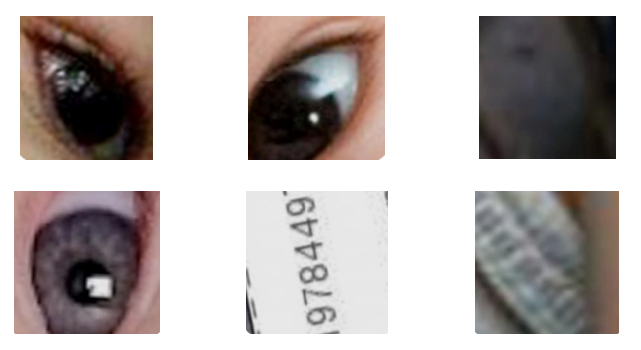

### Salvataggio Dati

Infine, è stata aggiunta la funzione write_list_to_file() che salva le informazioni date in output dall’algoritmo in un file formato .csv.

##### Codice preprocessing

In [ ]:
import os
import time
import threading
import multiprocessing
import math
from pylab import *
import PIL.Image as im
import csv
import sys
import pandas as pd
from imutils import face_utils
import numpy as np
import argparse
import imutils
import dlib
import cv2
from PIL import ImageFont
from PIL import Image
from PIL import ImageDraw
from string import Template
import string

#--La funzione scelta consente di poter scegliere con quale tipologia di ragnatela avviare il pre-processing--#
def scelta():
    print("E' possibile scegliere tra 4 configurazioni: ")
    print("   1 - 4 cerchi 4 fette Variante 4")
    print("   2 - 4 cerchi 4 fette Variante 2")
    print("   3 - 4 cerchi 3 fette ")
    print("   4 - 5 cerchi 4 fette")
    numero = int(input("Quale configurazione scegli? "))
    if numero > 4 or numero < 1:
        print("Parametro errato.")
        exit(0)
    return numero

def distanza(x1, y1, x2, y2):
    x12 = (x2 - x1) * (x2 - x1)
    y12 = (y2 - y1) * (y2 - y1)
    xy = x12 + y12
    dist = math.sqrt(xy)
    return dist

#Alla funzione aggiungi vengono passati due ulteriori parametri cerchi e scelta_config
#cerchi: è necessaria per specificare in quante parti deve essere diviso il raggio per formare la ragatela
#scelta_config: è necessaria per specificare con quale configurazione bisogna creare la ragnatela
def aggiungi(xcentro, ycentro, rax, xpunto, ypunto, distNaso, coeff, cerchi, scelta_config):

    settore = np.zeros(3) #cerchio, quadrante, fetta
    # distNaso =  distanza dal naso
    a = 0  # a = raggioStart

    conf = [
        ['4C_4S_var4', 4 * rax / 10, 7 * rax / 10, 9 * rax / 10],
        ['4C_4S_var2', 8 * rax / 15, 12 * rax / 15, 14 * rax / 15],
        ['4C_3S_inv', rax/4, rax/2, 3 * rax / 4],
        ['5C_4S_inv', rax / 5, 2 * rax / 5, 3 * rax / 5, 4 * rax / 5]]

    #---------------------------- anello ----------------------------#
    #definisce in quale anello ci troviamo analizzando la distanza dal naso
    #non utilizza più i parametri b1,b2, etc ma li prende dalla lista conf, l'indice viene passato alla funzione quando chiamata
    if( distNaso > a and distNaso <= conf[scelta_config][1]):
        settore[0] = 1
    elif(distNaso > conf[scelta_config][1] and distNaso <= conf[scelta_config][2]):
        settore[0] = 2
    elif(distNaso > conf[scelta_config][2] and distNaso <= conf[scelta_config][3]):
        settore[0] = 3
    elif (cerchi == 5):     #è stato aggiunto un if per prevedere il quinto cerchio, non previsto nell'algoritmo fornito
        if(distNaso > conf[scelta_config][3] and distNaso <= conf[scelta_config][4]):
            settore[0] = 4
        else:
            settore[0] = 5
    else:
        settore [0] = 4
    #---------------------------- quadrante --------------------------#
    #definisce in quale quadrante ci troviamo in base alle coordinate del punto
    if (xpunto <= xcentro and y <= ycentro):
        # il punto appartiene al quadrante in alto a sinistra
        settore[1] = 2
    elif (x <= xnose and y >= ynose):
        # il punto appartiene al quadrante in basso a sinistra
        settore[1] = 3
    elif (x >= xnose and y <= ynose):
        # il punto appartiene al quadrante in alto a destra
        settore[1] = 1
    else:
        # il punto appartiene al quadrante in basso a destra
        settore[1] = 4
#------------------------- Fetta del quadrante -----------------------#
    b = 90  / fetteQ      #grado Stop
    i = 1                 #in quale fetta cade il punto. i = [1, fette]

    radang_a = 0                    # radiante Start
    radang_b = math.radians(b)      # radiante Stop
    tng_a = math.tan(radang_a)
    tng_b = math.tan(radang_b)

    #fetta
    while(settore[2] == 0 and b < 90):
        if coeff > tng_a and coeff <= tng_b:
            settore[2] = i
        b = b + (90  / fetteQ)
        radang_b = math.radians(b)  # radiante Stop
        tng_a = tng_b
        tng_b = math.tan(radang_b)
        i = i+1

    if xpunto == xnose:
        settore[2] = 1

    if settore[2] == 0:
        settore[2] = fetteQ

    if settore[1] == 1 or settore[1] == 3:
        indice = int(fette * (settore[0]-1) + fetteQ * (settore[1] - 1) + abs(settore[2] - 4) - 1)

    else:
        indice = int(fette * (settore[0] - 1) + fetteQ * (settore[1] - 1) + settore[2] - 1)

    try:
        if xnose != xpunto or ynose != ypunto:           #il naso non ha settore
            volto[indice] = int(volto[indice] + 1)       #aggiunge 1 al contatore del settore contenente il landmark
    except:
        print("Errore, non è stato possibile addizionare il landmark al settore della ragnatela.")
        print("L'indice del landmark non addizionato  è:  " + str(indice))

#la funzione reponsive_resize riceve in input l'immagine del datataset e ne individua la presenza di un volto
#si è notato che alcuni volti a bassa risoluzione non vengono rilevati, si prova così ad effettuare l'individuazione
#a diverse risoluzioni fino ad un massimo di 2048, dopo tale risoluzione l'immagine o non contiene un volto o il
#volto presenta elementi di disturbo che ne impediscono l'individuazione
def responsive_resize(image):
    image = imutils.resize(image, width=256)    #ridimensiona l'immagine
    rects = detector(image, 1)                  #rileva la presenza di volti all'interno dell'immagine
    if len(rects) == 0:
        image = imutils.resize(image, width=512)
        rects = detector(image, 1)
        if len(rects) == 0:
            image = imutils.resize(image, width=1024)
            rects = detector(image, 1)
            if len(rects) == 0:
                image = imutils.resize(image, width=2048)
                rects = detector(image, 1)
                if len(rects) == 0:
                    print("Immagine non riconosciuta: " + nomeimmagine)
    return rects, image

def stampa_volto(x, y, w, h, shape, image):
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 153, 0), 2)
    for (x, y) in shape:
        cv2.circle(image, (x, y), 2, (255, 0, 0), -1)
    cv2.imshow('image', image)
    cv2.waitKey(0)

#la funzione write_list_to_file permette di salvare all'interno di un file csv il dataset trasformato,
#ovvero da un input di sole immagini ed etichette si avrà un nuovo dataset con un array contentente la ragnatela
#e le rispettive altre features note dal precedente dataset.
def write_list_to_file(guest_list, filename):
    contatore = 0
    with open(filename, "w", newline='') as csvfile:
        csvwriter = csv.writer(csvfile, delimiter = ';')
        for entries in guest_list:
            csvwriter.writerow(entries) #transf_blocks-->writerow
            contatore = contatore +1
        print("Scritti correttamente " + str(contatore) + " elementi. Il numero di elementi scartati  e': " + str(size_dataset - contatore))
    csvfile.close()

detector = dlib.get_frontal_face_detector()                                 #individua il volto il un immagine
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")   #individua i 68 landmark sul volto

# indice configurazione per reperire i dati del raggio nella lista configurazioni in aggiungi, tale parametro va passato ad ogni chiamata di aggiungi
# 0 - C4_4S_var4
# 1 - C4_4S_var2
# 2 - C4_3S_inv
# 3 - C5_4S_inv
numero_scelta = int(scelta())
if numero_scelta==1:
    anelli = 4
    fetteQ = 4   # fette per quadrante
    variante = 'var4'
elif numero_scelta == 2:
    anelli = 4
    fetteQ = 4  # fette per quadrante
    variante = 'var2'
elif numero_scelta == 3:
    anelli = 4
    fetteQ = 3  # fette per quadrante
    variante = 'inv'
else:
    anelli = 5
    fetteQ = 4  # fette per quadrante
    variante = 'inv'

fette = fetteQ * 4                  #calcolo fette per anello
n_quadranti = anelli * fette        #calcolo numero di settori totali

lista_immagini = os.listdir('Dataset/utkface/image')
size_dataset = len(lista_immagini)
print("Il dataset  ha una dimensione di " + str(size_dataset) + " elementi")
lista = []                  #lista in cui andranno inseriti tutti gli array che rappresentano la ragnatela del volto presente nelle immagini (una per ogni immagine)
num_volto = 0               #conta quante immagini abbiamo processato

for img in lista_immagini:
    if img.find(".jpg") > 0:
        path_immagine = "Dataset/utkface/image/" + str(img)
        foto = cv2.imread(path_immagine)
        volto = [0 for i in range(n_quadranti)]                   #array che contengono un contatore per ogni settore della ragnatela
        nomeimmagine = str(img)
        try:
            eta, sesso, razza, data = nomeimmagine.split('_')     #si ricavano età sesso e razza dal nome dell'immagine
        except ValueError:                                        #alcuni file non sono etichettati correttamente, verranno scartati
            continue

        rects, foto = responsive_resize(foto)                     #si individua il volto con la funzione detector presente all'interno di reponsive_resize()
        gray = cv2.cvtColor(foto, cv2.COLOR_BGR2GRAY)
        xnose, ynose = 0, 0     #coordinate naso
        raggio = 0              #raggio della ragnatela
        xlont, ylont = 0, 0     #coordinate del landmark più lontano
        distanza_punto = 0      #variabile che utilizziamo per calcolare la distanza dei landmark dal naso e trovare il raggio
        m = 0                   #coefficiente che diamo alla funzione aggiungi
        d = 0                   #distanza tra punto e naso che diamo alla funzione aggiungi
        #il ciclo viene utilizzato nel caso in cui in un'immagine abbiamo più di un volto, se non trova volti va all'immagine successiva
        for (i, rect) in enumerate(rects):
            shape = predictor(gray, rect)
            shape = face_utils.shape_to_np(shape)
            (x, y, w, h) = face_utils.rect_to_bb(rect)
            #stampa_volto(x, y, w, h, shape, foto)
            xnose = shape[33][0]        #il naso ha il landmark numero 33
            ynose = shape[33][1]        #il naso ha il landmark numero 33
            for (x, y) in shape:        #scegliamo il raggio guardando le coordinate più distanti
                distanza_punto = distanza(xnose, ynose, x, y)
                if(distanza_punto > raggio):
                    raggio = distanza_punto
                    xlont = x   #coordinata x del punto più lontano dal naso
                    ylont = y   #coordinata y del punto più lontano dal naso

            for(x,y) in shape:
                settore = [0,0,0]          #settore[0] = cerchio - settore[1] = quadrante - settore[2] = fetta
                if(y == ynose):            #calcola il coefficiente per ogni punto da utilizzare nella funzione aggiungi
                    m = 0
                else:
                    m = (x - xnose)/(y-ynose)
                m = abs(m)                 #valore assoluto di m
                d = distanza(xnose, ynose, x,y)
                aggiungi(xnose, ynose, raggio, x, y, d, m, anelli, numero_scelta-1)
            #aggiunto anelli e per settare i parametri della ragnatela in modo "responsive"
            #aggiungiamo all'array di settori le 3 informazioni derivate dal nome: eta, razza, sesso, nome file
            volto.append(int(eta))
            volto.append(int(razza))
            volto.append(int(sesso))
            volto.append(nomeimmagine)
            lista.append(volto)              #salviamo l'array dei settori nella lista
            num_volto = num_volto + 1        #contatore numero di immagini processate
        if (num_volto % 200) == 0:           #stampa l'avanzamento del processo
            print("Ho processato " + str(num_volto) + " elementi")

#viene salva la lista di ragnatele con le rispettive features all'interno di un file csv con il numero che indica la configurazione
write_list_to_file(lista, 'Dataset-'+str(anelli)+'C_'+str(fetteQ)+'S_'+str(variante)+'.csv')

# Classificatori

In tale capitolo si analizzerà in dettaglio il percorso di ricerche effettuate per raggiungere la soluzione migliore in termini di accuratezza.

Le tipologie di modelli di apprendimento supervisionati sviluppati per la risoluzione del problema di classificazione sono:

•	Support Vector Machine (SVM);

•	rete neurale con vettore ragnatela;

•	rete neurale convoluzionale;

•	rete neurale ibrida immagine e ragnatela.

Nei successivi paragrafi si procederà ad analizzare nel dettaglio ogni tipologia di modello ed i relativi risultati utilizzando le configurazioni assegnate.

## Classificatore SVM

Le Support Vector Machines (SVM) sono dei modelli di apprendimento supervisionato associati ad algoritmi di apprendimento per la classificazione e la regressione. Dato un insieme di esempi per l'addestramento, ognuno dei quali etichettato con la classe di appartenenza fra le due possibili classi, un algoritmo di addestramento per le SVM costruisce un modello che assegna i nuovi esempi a una delle due classi, ottenendo quindi un classificatore lineare binario.

Un modello SVM è una rappresentazione degli esempi come punti nello spazio, mappati in modo tale che gli esempi appartenenti alle due diverse categorie siano chiaramente separati da uno spazio il più possibile ampio. I nuovi esempi sono quindi mappati nello stesso spazio e la predizione della categoria alla quale appartengono viene fatta sulla base del lato nel quale ricade.
Nel nostro progetto l’SVM è stata la prima soluzione implementata e testata. Non ha prodotto risultati ottimi, considerando il punteggio di accuratezza pari a 0.74.

Di seguito i risultati ottenuti testando le 4 configurazioni:


| Configurazione|Accuracy    |
|:---------------|:------------|
|   4C_4S_var4  | 0.72       |
|   4C_4S_var2  | 0.73       |
|   5C_4S_inv   | 0.74       |
|   4C_3S_inv   | 0.71       |

##### Codice SVM

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import sklearn
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
from sklearn.svm import LinearSVC

dataset = pd.read_csv('Dataset/utkface/csv/Dataset-5C_4S_inv.csv', sep=';')
X = dataset.iloc[:, 0:80].values
print(X.shape)
y = dataset.iloc[:, 81].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0 )
classifier = SVC()
history = classifier.fit(X_train, y_train)
predicted = classifier.predict(X_test)
print("Classification report for classifier %s:\n%s\n"
      % (classifier, classification_report(y_test, predicted)))
disp = sklearn.metrics.plot_confusion_matrix(classifier, X_test, y_test)
disp.figure_.suptitle("Confusion Matrix")
print("Confusion matrix:\n%s" % disp.confusion_matrix)
print("Accuracy Score:")
print(accuracy_score(y_test, predicted))


## Reti Neurali

Le reti neurali artificiali sono modelli matematici composti da neuroni artificiali di ispirazione alle reti neurali biologiche e sono utilizzate per risolvere problemi ingegneristici di Intelligenza Artificiale.
Volendo dare una definizione più dettagliata potremmo dire che le reti neurali sono modelli di calcolo matematico-informatici basati sul funzionamento delle reti neurali biologiche, ossia modelli costituiti da interconnessioni di informazioni; tali interconnessioni derivano da neuroni artificiali e processi di calcolo basati sul modello delle scienze cognitive chiamato “connessionismo”.

## Rete neurale con vettore ragnatela


Il secondo modello sviluppato utilizza una rete neurale a cui viene dato in input il dataset ricevuto in output dall’algoritmo “ragnatela”, quindi, per ogni immagine abbiamo in input un array di interi con un size variabile in base alla configurazione scelta.

Per massimizzare l’accuratezza dei risultati sono stati variati in diversi modi i seguenti parametri:

•	batch size ed Epoch del Fit;

percentuale di dropout ad ogni layer;

•	batch normalization dei layer intermedi;

•	percentuale di elementi dati in Validation e in Test;

•	dimensione e numero dei layer intermedi;

•	tipologia di optimizer per la compilazione del classificatore;

•	tipologia di loss per la compilazione del classificatore;

•	tipologia di funzione di attivazione.

È stata inoltre tentata l’aggiunta delle due features riguardanti età e razza dei volti all’array ragnatela, senza notare rilevanti miglioramenti.

I risultati ottenuti sono i seguenti:

| Configurazione| Loss   | Accuracy   |
|:---------------|:--------|:------------|
|   4C_4S_var4  | 0.54   | 0.72       |
|   4C_4S_var2  | 0.54   | 0.73       |
|   5C_4S_inv   | 0.50   | 0.75       |
|   4C_3S_inv   | 0.55   | 0.70       |


##### Configurazione 4C_4S_var4

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras import optimizers
from sklearn.utils import shuffle
from keras.models import load_model

dataset = pd.read_csv('Dataset/utkface/csv/Dataset-4C_4S_var4.csv', sep=';')
print(dataset)
dataset = shuffle(dataset)
print(dataset)

x = dataset.iloc[:, 0:64].values    #carica in x la lista di array che rappresentano le ragnatele per ogni volto, in questa configurazione ha dimensione 80
y = dataset.iloc[:, 66].values      #carica in y l'etichetta riguardante il sesso
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 1)    #esegue lo split del dataset in train set e test set

#classifier = load_model('spider4C_4S_var4.h5')                                                  #carica il classificatore già allenato per test successivi all'allenamento

classifier = Sequential()
classifier.add(Dense(output_dim = 256, init = 'uniform', activation = 'relu', input_dim = 64 ))
classifier.add(Dense(output_dim = 256, init = 'uniform', activation = 'relu'))
classifier.add(Dense(output_dim = 1, init = 'uniform', activation = 'sigmoid'))

classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy' , metrics = ['accuracy'] )

history = classifier.fit(x_train, y_train, batch_size = 4096, nb_epoch = 25, validation_split=0.15)

classifier.save('spider4C_4S_var4.h5')       #salva il modello al termine dell'allenamento, in modo da poterlo caricare successivamente senza dover effettuare di nuovo l'allenamento

y_pred = classifier.predict(x_test)         #esegue il test con il test set creato prima dell'allenamento
y_pred_bool = (y_pred > 0.5)
pd.DataFrame(y_pred_bool)

cm = confusion_matrix(y_test, y_pred_bool)  #crea la matrice di confuzione in cui verranno riportati i TP, TF, FP, FT
print(cm)

print("Classification report\n%s\n" % (metrics.classification_report(y_test, y_pred_bool)))     #stampa i risultati ottenuti

#grafico accuratezza
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
#grafico loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

##### Configurazione 4C_4S_var2

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras import optimizers
from sklearn.utils import shuffle
from keras.models import load_model

dataset = pd.read_csv('Dataset/utkface/csv/Dataset-4C_4S_var2.csv', sep=';')
print(dataset)
dataset = shuffle(dataset)
print(dataset)

x = dataset.iloc[:, 0:64].values    #carica in x la lista di array che rappresentano le ragnatele per ogni volto, in questa configurazione ha dimensione 80
y = dataset.iloc[:, 66].values      #carica in y l'etichetta riguardante il sesso
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 1)    #esegue lo split del dataset in train set e test set

#classifier = load_model('spider4C_4S_var2.h5')                                                  #carica il classificatore già allenato per test successivi all'allenamento

classifier = Sequential()
classifier.add(Dense(output_dim = 256, init = 'uniform', activation = 'relu', input_dim = 64 ))
classifier.add(Dense(output_dim = 256, init = 'uniform', activation = 'relu'))
classifier.add(Dense(output_dim = 1, init = 'uniform', activation = 'sigmoid'))

classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy' , metrics = ['accuracy'] )

history = classifier.fit(x_train, y_train, batch_size = 4096, nb_epoch = 25, validation_split=0.15)

classifier.save('spider4C_4S_var2.h5')       #salva il modello al termine dell'allenamento, in modo da poterlo caricare successivamente senza dover effettuare di nuovo l'allenamento

y_pred = classifier.predict(x_test)         #esegue il test con il test set creato prima dell'allenamento
y_pred_bool = (y_pred > 0.5)
pd.DataFrame(y_pred_bool)

cm = confusion_matrix(y_test, y_pred_bool)  #crea la matrice di confuzione in cui verranno riportati i TP, TF, FP, FT
print(cm)

print("Classification report\n%s\n" % (metrics.classification_report(y_test, y_pred_bool)))     #stampa i risultati ottenuti

#grafico accuratezza
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
#grafico loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

##### Configurazione 4C_3S_inv

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras import optimizers
from sklearn.utils import shuffle
from keras.models import load_model

dataset = pd.read_csv('Dataset/utkface/csv/Dataset-4C_3S_inv.csv', sep=';')
print(dataset)
dataset = shuffle(dataset)
print(dataset)

x = dataset.iloc[:, 0:48].values    #carica in x la lista di array che rappresentano le ragnatele per ogni volto, in questa configurazione ha dimensione 80
y = dataset.iloc[:, 49].values      #carica in y l'etichetta riguardante il sesso
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 1)    #esegue lo split del dataset in train set e test set

#classifier = load_model('spider4C_3S_inv.h5')                                                  #carica il classificatore già allenato per test successivi all'allenamento

classifier = Sequential()
classifier.add(Dense(output_dim = 256, init = 'uniform', activation = 'relu', input_dim = 48 ))
classifier.add(Dense(output_dim = 256, init = 'uniform', activation = 'relu'))
classifier.add(Dense(output_dim = 1, init = 'uniform', activation = 'sigmoid'))

classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy' , metrics = ['accuracy'] )

history = classifier.fit(x_train, y_train, batch_size = 4096, nb_epoch = 25, validation_split=0.15)

classifier.save('spider4C_3S_inv.h5')       #salva il modello al termine dell'allenamento, in modo da poterlo caricare successivamente senza dover effettuare di nuovo l'allenamento

y_pred = classifier.predict(x_test)         #esegue il test con il test set creato prima dell'allenamento
y_pred_bool = (y_pred > 0.5)
pd.DataFrame(y_pred_bool)

cm = confusion_matrix(y_test, y_pred_bool)  #crea la matrice di confuzione in cui verranno riportati i TP, TF, FP, FT
print(cm)

print("Classification report\n%s\n" % (metrics.classification_report(y_test, y_pred_bool)))     #stampa i risultati ottenuti

#grafico accuratezza
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
#grafico loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

##### Configurazione 5C_4S_inv

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras import optimizers
from sklearn.utils import shuffle
from keras.models import load_model

dataset = pd.read_csv('Dataset/utkface/csv/Dataset-5C_4S_inv.csv', sep=';')
print(dataset)
dataset = shuffle(dataset)
print(dataset)

x = dataset.iloc[:, 0:80].values    #carica in x la lista di array che rappresentano le ragnatele per ogni volto, in questa configurazione ha dimensione 80
y = dataset.iloc[:, 81].values      #carica in y l'etichetta riguardante il sesso
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 1)    #esegue lo split del dataset in train set e test set

#classifier = load_model('spider5C_4S_inv.h5')                                                  #carica il classificatore già allenato per test successivi all'allenamento

classifier = Sequential()
classifier.add(Dense(output_dim = 256, init = 'uniform', activation = 'relu', input_dim = 80 ))
classifier.add(Dense(output_dim = 256, init = 'uniform', activation = 'relu'))
classifier.add(Dense(output_dim = 1, init = 'uniform', activation = 'sigmoid'))

classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy' , metrics = ['accuracy'] )

history = classifier.fit(x_train, y_train, batch_size = 4096, nb_epoch = 25, validation_split=0.15)

classifier.save('spider5C_4S_inv.h5')       #salva il modello al termine dell'allenamento, in modo da poterlo caricare successivamente senza dover effettuare di nuovo l'allenamento

y_pred = classifier.predict(x_test)         #esegue il test con il test set creato prima dell'allenamento
y_pred_bool = (y_pred > 0.5)
pd.DataFrame(y_pred_bool)

cm = confusion_matrix(y_test, y_pred_bool)  #crea la matrice di confuzione in cui verranno riportati i TP, TF, FP, FT
print(cm)

print("Classification report\n%s\n" % (metrics.classification_report(y_test, y_pred_bool)))     #stampa i risultati ottenuti

#grafico accuratezza
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
#grafico loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Rete Neurale Convoluzionale

Per conoscere la differenza di accuratezza tra una rete neurale basata sul solo array ragnatela e una rete neurale che prende in input l’intera immagine è stata realizzata una rete neurale convoluzionale per la classificazione dei generi.

La Convolutional Neural Network (CNN) rappresenta un’architettura di rete neurale artificiale di grande successo nelle applicazioni di visione artificiale e ampiamente utilizzata anche in applicazioni che processano media come audio e video.

L’applicazione più popolare di rete neurale convoluzionale resta comunque quella di identificare, da parte di un computer, cosa un’immagine rappresenta.

Per massimizzare l’accuratezza del risultato sono stati variati i seguenti parametri: 

•	batch size ed Epoch del Fit;

•	percentuale di dropout;

•	batch normalization dei Layer intermedi;

•	percentuale di elementi dati in Validation ed in Test;

•	dimensione e numero dei layer intermedi;

•	tipo di funzione di attivazione.

L’accuracy riscontrata utilizzando questa tipologia di rete neurale è 0.88.



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import keras
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from keras.layers import Dropout
from keras.layers import BatchNormalization
from joblib import dump, load
import cv2
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Conv2D, MaxPooling2D, Input, Dense, Flatten, concatenate
from keras.models import Model
import numpy as np
from keras.models import load_model
import itertools

#carica il dataset per recuperare il nome delle immagini da processare
#si è scelto di caricare le stesse immagini risultate valide nel pre-processing
dataset = pd.read_csv('Dataset-4C_4S_var4.csv', sep=';')

z_data = []
for index, row in dataset.iterrows():
    nome_file = str(row[67])
    path_immagine = "Dataset/" + nome_file
    face = cv2.imread(path_immagine)
    face = cv2.resize(face, (32, 32))
    z_data.append(face)
    if (index % 500) == 0:
        print("Ho processato " + str(index) + " elementi")

z = np.squeeze(z_data)
print(z.shape)

z = z.astype('float32')
z /= 255
print(z.shape)


y = dataset.iloc[:, 66].values              #alla 66 colonna è specificato il sesso di ogni volto nelle immagini
z_train, z_test, y_train, y_test = train_test_split(z, y, test_size=0.2, random_state=0)

#model = load_model('image.h5')   #carica il classificatore già allenato per test successivi all'allenamento

inputA = Input(shape=(32, 32, 3))           #rete neurale convoluzionale
A = Conv2D(64, (3, 3))(inputA)
A = MaxPooling2D((2, 2))(A)
A = Conv2D(32, (3, 3))(A)
A = MaxPooling2D((2, 2))(A)
A = Flatten()(A)
A = Dense(256, activation="relu")(A)
A = Dense(256, activation="relu")(A)
A = Dense(1, activation="sigmoid")(A)
model = Model(inputs=inputA, outputs=A)
model.summary()

model.compile(optimizer = 'adam', loss = 'binary_crossentropy' , metrics = ['accuracy'] )

history = model.fit(z_train, y_train, epochs=25, batch_size= 4096, validation_split=0.15)
model.save('image.h5')                      #salva il modello al termine dell'allenamento, in modo da poterlo caricare successivamente senza dover effettuare di nuovo l'allenamento

preds = model.predict(z_test)               #esegue il test con il test set creato prima dell'allenamento

preds_bool = (preds > 0.5)
pd.DataFrame(preds_bool)
cm = confusion_matrix(y_test, preds_bool)   #crea la matrice di confuzione in cui verranno riportati i TP, TF, FP, FT
print(cm)
print("Classification report\n%s\n" % (metrics.classification_report(y_test, preds_bool)))      #stampa i risultati ottenuti

#grafico accuratezza
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
#grafico loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


## Rete Neuarle 'Ibrida'

Un passo successivo è stata l’implementazione di una rete neurale ibrida, che unisce la rete neurale convoluzionale, che prende in input le sole immagini, con la rete neurale che prende in input l’array ragnatela.

Le due reti si concatenano in un'unica rete che fornirà in output un risultato unico.

Il modello della rete neurale convoluzionale utilizzato è il medesimo della rete convoluzionale analizzata nella soluzione precedente, in modo da poter riscontrare miglioramenti dovuti alla sola aggiunta della rete neurale con input l’array ragnatela.

Anche in questo caso per massimizzare l’accuratezza del risultato sono stati variati i seguenti parametri: 

•	patch e numero di epoche del Fit;

•	percentuale di dropout;

•	batch normalization dei layer intermedi;

•	percentuale di elementi dati in Validation e in Test;

•	dimensione e numero dei layer intermedi;

•	tipo di funzione di attivazione.

I risultati ottenuti sono i seguenti:

| Configurazione| Loss   | Accuracy   |
|:---------------|:--------|:------------|
|   4C_4S_var4  | 0.25   | 0.89       |
|   4C_4S_var2  | 0.27   | 0.88       |
|   5C_4S_inv   | 0.27   | 0.88       |
|   4C_3S_inv   | 0.26   | 0.88       |

##### Configurazione 4C_4S_var4

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import keras
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from keras.layers import Dropout
from keras.layers import BatchNormalization
import cv2
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Conv2D, MaxPooling2D, Input, Dense, Flatten, concatenate
from keras.models import Model
import numpy as np
from keras.models import load_model
import itertools
from sklearn.metrics import accuracy_score

dataset = pd.read_csv('Dataset/utkface/csv/Dataset-4C_4S_var4.csv', sep=';')    #carica il dataset csv contenente la ragliatela e altre features

z_data = []
for index, row in dataset.iterrows():   #carica tutti i file immagini del dataset di cui si è riusciti a calcolare la ragatela
    nome_file = str(row[67])
    path_immagine = "Dataset/utkface/image/" + nome_file
    face = cv2.imread(path_immagine)
    face = cv2.resize(face, (32, 32))
    z_data.append(face)
    if (index % 500) == 0:
        print("Ho processato " + str(index) + " elementi")

z = np.squeeze(z_data)
print(z.shape)

z = z.astype('float32')
z /= 255
print(z.shape)

x = dataset.iloc[:, 0:64].values        #assegna ad x la ragnatela che in questa configurazione ha dimensione 64
y = dataset.iloc[:, 66].values          #assegna ad y il target ovvero il sesso

x_train, x_test_temp, y_train, y_test_temp = train_test_split(x, y, test_size=0.2, random_state=0)      #creazione train e test set l'array ragnatela
z_train, z_test_temp, yy_train, yy_test_temp = train_test_split(z, y, test_size=0.2, random_state=0)    #creazione train e test set per le immagini

#model = load_model('image4C_4S_var4.h5') #salva il modello al termine dell'allenamento, in modo da poterlo caricare successivamente senza dover effettuare di nuovo l'allenamento

#il modello si compone di due reti che si concatenano durante la loro esecuzione
inputA = Input(shape=(32, 32, 3))   #rappresenta i dati dell'immagine
inputB = Input(shape=(64,))         #rappresenta la ragnatela

A = Conv2D(64, (3, 3))(inputA)      #il ramo A è identico alla rete neurale convoluzionale sviluppata in precedenza per le sole immagini
A = MaxPooling2D((2, 2))(A)
A = Conv2D(32, (3, 3))(A)
A = MaxPooling2D((2, 2))(A)
A = Flatten()(A)
A = Dense(256, activation="relu")(A)
A = Dense(256, activation="relu")(A)
A = Model(inputs=inputA, outputs=A)
A.summary()

B = Dense(64, activation="relu")(inputB)        #il ramo B prende in input la ragnatela per ogni immagine
B = Model(inputs=inputB, outputs=B)
B.summary()
combined = concatenate([A.output, B.output])    #i due rami si conatenano in un ulteriore rete fully connected

C = Dense(256, activation="relu")(combined)
C = Dense(256, activation="relu")(C)
C = Dense(1, activation="sigmoid")(C)

model = Model(inputs=[A.input, B.input], outputs=C)
model.summary()

model.compile(optimizer = 'adam', loss = 'binary_crossentropy' , metrics = ['accuracy'] )

history = model.fit([z_train, x_train], yy_train, epochs=25, batch_size= 4096, validation_split=0.15)
model.save('image4C_4S_var4.h5')                     #salva il modello al termine dell'allenamento, in modo da poterlo caricare successivamente senza dover effettuare di nuovo l'allenamento

preds = model.predict([z_test_temp, x_test_temp])   #esegue il test con i test set creati prima dell'allenamento

preds_bool = (preds > 0.5)
pd.DataFrame(preds_bool)
cm = confusion_matrix(y_test_temp, preds_bool)      #crea la matrice di confuzione in cui verranno riportati i TP, TF, FP, FT
print(cm)
print("Classification report\n%s\n" % (metrics.classification_report(y_test_temp, preds_bool)))

#grafico accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

#grafico loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()



##### Configurazione 4C_4S_var2

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import keras
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from keras.layers import Dropout
from keras.layers import BatchNormalization
import cv2
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Conv2D, MaxPooling2D, Input, Dense, Flatten, concatenate
from keras.models import Model
import numpy as np
from keras.models import load_model
import itertools
from sklearn.metrics import accuracy_score

dataset = pd.read_csv('Dataset/utkface/csv/Dataset-4C_4S_var2.csv', sep=';')    #carica il dataset csv contenente la ragliatela e altre features

z_data = []
for index, row in dataset.iterrows():   #carica tutti i file immagini del dataset di cui si è riusciti a calcolare la ragatela
    nome_file = str(row[67])
    path_immagine = "Dataset/utkface/image/" + nome_file
    face = cv2.imread(path_immagine)
    face = cv2.resize(face, (32, 32))
    z_data.append(face)
    if (index % 500) == 0:
        print("Ho processato " + str(index) + " elementi")

z = np.squeeze(z_data)
print(z.shape)

z = z.astype('float32')
z /= 255
print(z.shape)

x = dataset.iloc[:, 0:64].values        #assegna ad x la ragnatela che in questa configurazione ha dimensione 64
y = dataset.iloc[:, 66].values          #assegna ad y il target ovvero il sesso

x_train, x_test_temp, y_train, y_test_temp = train_test_split(x, y, test_size=0.2, random_state=0)      #creazione train e test set l'array ragnatela
z_train, z_test_temp, yy_train, yy_test_temp = train_test_split(z, y, test_size=0.2, random_state=0)    #creazione train e test set per le immagini

#model = load_model('image4C_4S_var2.h5') #salva il modello al termine dell'allenamento, in modo da poterlo caricare successivamente senza dover effettuare di nuovo l'allenamento

#il modello si compone di due reti che si concatenano durante la loro esecuzione
inputA = Input(shape=(32, 32, 3))   #rappresenta i dati dell'immagine
inputB = Input(shape=(64,))         #rappresenta la ragnatela

A = Conv2D(64, (3, 3))(inputA)      #il ramo A è identico alla rete neurale convoluzionale sviluppata in precedenza per le sole immagini
A = MaxPooling2D((2, 2))(A)
A = Conv2D(32, (3, 3))(A)
A = MaxPooling2D((2, 2))(A)
A = Flatten()(A)
A = Dense(256, activation="relu")(A)
A = Dense(256, activation="relu")(A)
A = Model(inputs=inputA, outputs=A)
A.summary()

B = Dense(64, activation="relu")(inputB)        #il ramo B prende in input la ragnatela per ogni immagine
B = Model(inputs=inputB, outputs=B)
B.summary()
combined = concatenate([A.output, B.output])    #i due rami si conatenano in un ulteriore rete fully connected

C = Dense(256, activation="relu")(combined)
C = Dense(256, activation="relu")(C)
C = Dense(1, activation="sigmoid")(C)

model = Model(inputs=[A.input, B.input], outputs=C)
model.summary()

model.compile(optimizer = 'adam', loss = 'binary_crossentropy' , metrics = ['accuracy'] )

history = model.fit([z_train, x_train], yy_train, epochs=25, batch_size= 4096, validation_split=0.15)
model.save('image4C_4S_var2.h5')                     #salva il modello al termine dell'allenamento, in modo da poterlo caricare successivamente senza dover effettuare di nuovo l'allenamento

preds = model.predict([z_test_temp, x_test_temp])   #esegue il test con i test set creati prima dell'allenamento

preds_bool = (preds > 0.5)
pd.DataFrame(preds_bool)
cm = confusion_matrix(y_test_temp, preds_bool)      #crea la matrice di confuzione in cui verranno riportati i TP, TF, FP, FT
print(cm)
print("Classification report\n%s\n" % (metrics.classification_report(y_test_temp, preds_bool)))

#grafico accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

#grafico loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


##### Configurazione 4C_3S_inv

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import keras
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from keras.layers import Dropout
from keras.layers import BatchNormalization
import cv2
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Conv2D, MaxPooling2D, Input, Dense, Flatten, concatenate
from keras.models import Model
import numpy as np
from keras.models import load_model
import itertools
from sklearn.metrics import accuracy_score

dataset = pd.read_csv('Dataset/utkface/csv/Dataset-4C_3S_inv.csv', sep=';')    #carica il dataset csv contenente la ragliatela e altre features

z_data = []
for index, row in dataset.iterrows():   #carica tutti i file immagini del dataset di cui si è riusciti a calcolare la ragatela
    nome_file = str(row[51])
    path_immagine = "Dataset/utkface/image/" + nome_file
    face = cv2.imread(path_immagine)
    face = cv2.resize(face, (32, 32))
    z_data.append(face)
    if (index % 500) == 0:
        print("Ho processato " + str(index) + " elementi")

z = np.squeeze(z_data)
print(z.shape)

z = z.astype('float32')
z /= 255
print(z.shape)

x = dataset.iloc[:, 0:48].values        #assegna ad x la ragnatela che in questa configurazione ha dimensione 64
y = dataset.iloc[:, 49].values          #assegna ad y il target ovvero il sesso

x_train, x_test_temp, y_train, y_test_temp = train_test_split(x, y, test_size=0.2, random_state=0)      #creazione train e test set l'array ragnatela
z_train, z_test_temp, yy_train, yy_test_temp = train_test_split(z, y, test_size=0.2, random_state=0)    #creazione train e test set per le immagini

#model = load_model('image4C_3S_inv.h5') #salva il modello al termine dell'allenamento, in modo da poterlo caricare successivamente senza dover effettuare di nuovo l'allenamento

#il modello si compone di due reti che si concatenano durante la loro esecuzione
inputA = Input(shape=(32, 32, 3))   #rappresenta i dati dell'immagine
inputB = Input(shape=(48,))         #rappresenta la ragnatela

A = Conv2D(64, (3, 3))(inputA)      #il ramo A è identico alla rete neurale convoluzionale sviluppata in precedenza per le sole immagini
A = MaxPooling2D((2, 2))(A)
A = Conv2D(32, (3, 3))(A)
A = MaxPooling2D((2, 2))(A)
A = Flatten()(A)
A = Dense(256, activation="relu")(A)
A = Dense(256, activation="relu")(A)
A = Model(inputs=inputA, outputs=A)
A.summary()

B = Dense(48, activation="relu")(inputB)        #il ramo B prende in input la ragnatela per ogni immagine
B = Model(inputs=inputB, outputs=B)
B.summary()
combined = concatenate([A.output, B.output])    #i due rami si conatenano in un ulteriore rete fully connected

C = Dense(256, activation="relu")(combined)
C = Dense(256, activation="relu")(C)
C = Dense(1, activation="sigmoid")(C)

model = Model(inputs=[A.input, B.input], outputs=C)
model.summary()

model.compile(optimizer = 'adam', loss = 'binary_crossentropy' , metrics = ['accuracy'] )

history = model.fit([z_train, x_train], yy_train, epochs=25, batch_size= 4096, validation_split=0.15)
model.save('image4C_3S_inv.h5')                     #salva il modello al termine dell'allenamento, in modo da poterlo caricare successivamente senza dover effettuare di nuovo l'allenamento

preds = model.predict([z_test_temp, x_test_temp])   #esegue il test con i test set creati prima dell'allenamento

preds_bool = (preds > 0.5)
pd.DataFrame(preds_bool)
cm = confusion_matrix(y_test_temp, preds_bool)      #crea la matrice di confuzione in cui verranno riportati i TP, TF, FP, FT
print(cm)
print("Classification report\n%s\n" % (metrics.classification_report(y_test_temp, preds_bool)))

#grafico accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

#grafico loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


##### Configurazione 5C_4S_inv

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import keras
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from keras.layers import Dropout
from keras.layers import BatchNormalization
import cv2
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Conv2D, MaxPooling2D, Input, Dense, Flatten, concatenate
from keras.models import Model
import numpy as np
from keras.models import load_model
import itertools
from sklearn.metrics import accuracy_score

dataset = pd.read_csv('Dataset/utkface/csv/Dataset-5C_4S_inv.csv', sep=';')    #carica il dataset csv contenente la ragliatela e altre features

z_data = []
for index, row in dataset.iterrows():   #carica tutti i file immagini del dataset di cui si è riusciti a calcolare la ragatela
    nome_file = str(row[83])
    path_immagine = "Dataset/utkface/image/" + nome_file
    face = cv2.imread(path_immagine)
    face = cv2.resize(face, (32, 32))
    z_data.append(face)
    if (index % 500) == 0:
        print("Ho processato " + str(index) + " elementi")

z = np.squeeze(z_data)
print(z.shape)

z = z.astype('float32')
z /= 255
print(z.shape)

x = dataset.iloc[:, 0:80].values        #assegna ad x la ragnatela che in questa configurazione ha dimensione 80
y = dataset.iloc[:, 81].values          #assegna ad y il target ovvero il sesso

x_train, x_test_temp, y_train, y_test_temp = train_test_split(x, y, test_size=0.2, random_state=0)      #creazione train e test set l'array ragnatela
z_train, z_test_temp, yy_train, yy_test_temp = train_test_split(z, y, test_size=0.2, random_state=0)    #creazione train e test set per le immagini

#model = load_model('image5C_4S_inv.h5') #salva il modello al termine dell'allenamento, in modo da poterlo caricare successivamente senza dover effettuare di nuovo l'allenamento

#il modello si compone di due reti che si concatenano durante la loro esecuzione
inputA = Input(shape=(32, 32, 3))   #rappresenta i dati dell'immagine
inputB = Input(shape=(80,))         #rappresenta la ragnatela

A = Conv2D(64, (3, 3))(inputA)      #il ramo A è identico alla rete neurale convoluzionale sviluppata in precedenza per le sole immagini
A = MaxPooling2D((2, 2))(A)
A = Conv2D(32, (3, 3))(A)
A = MaxPooling2D((2, 2))(A)
A = Flatten()(A)
A = Dense(256, activation="relu")(A)
A = Dense(256, activation="relu")(A)
A = Model(inputs=inputA, outputs=A)
A.summary()

B = Dense(80, activation="relu")(inputB)        #il ramo B prende in input la ragnatela per ogni immagine
B = Model(inputs=inputB, outputs=B)
B.summary()
combined = concatenate([A.output, B.output])    #i due rami si conatenano in un ulteriore rete fully connected

C = Dense(256, activation="relu")(combined)
C = Dense(256, activation="relu")(C)
C = Dense(1, activation="sigmoid")(C)

model = Model(inputs=[A.input, B.input], outputs=C)
model.summary()

model.compile(optimizer = 'adam', loss = 'binary_crossentropy' , metrics = ['accuracy'] )

history = model.fit([z_train, x_train], yy_train, epochs=25, batch_size= 4096, validation_split=0.15)
model.save('image5C_4S_inv.h5')                     #salva il modello al termine dell'allenamento, in modo da poterlo caricare successivamente senza dover effettuare di nuovo l'allenamento

preds = model.predict([z_test_temp, x_test_temp])   #esegue il test con i test set creati prima dell'allenamento

preds_bool = (preds > 0.5)
pd.DataFrame(preds_bool)
cm = confusion_matrix(y_test_temp, preds_bool)      #crea la matrice di confuzione in cui verranno riportati i TP, TF, FP, FT
print(cm)
print("Classification report\n%s\n" % (metrics.classification_report(y_test_temp, preds_bool)))

#grafico accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

#grafico loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()



# Ulteriori evidenze (Dataset CelebA)

Nel tentativo di ottenere una percentuale migliore in termini di accuratezza si è deciso di sottoporre in input al modello, con configurazione migliore nel test sulla rete neurale con sola ragnatela, una mole maggiore di dati per l’addestramento. Per questo motivo è stato scelto l’utilizzo del dataset CelebA. 

## Dataset CelebA

CelebFaces Attributes Dataset (CelebA) è un set di dati di volti con attributi su larga scala con oltre 200.000 immagini di celebrità, ognuna con 40 annotazioni di attributi. Le immagini in questo dataset coprono grandi variazioni di posa e di sfondi.

Tale dataset differisce da UTKFace per la tipologia di attributi utilizzati per etichettare le immagini e dalla dimensione dello stesso dataset; in UTKFace le etichette riguardano riferimenti biologici (razza, età e sesso), mentre in CelebA abbiamo un’attenzione maggiore sugli attributi riguardanti l’aspetto conferito alla persona da oggetti o segni di riconoscimento particolari (capelli ricci, occhiali, calvizie, baffi, make-up, etc..).


##### Codice preprocessing Dataset CelebA

In [ ]:
import os
import time
import threading
import multiprocessing
import math
from pylab import *
import PIL.Image as im
import csv
import sys
import pandas as pd

from imutils import face_utils
import numpy as np
import argparse
import imutils
import dlib
import cv2
from PIL import ImageFont
from PIL import Image
from PIL import ImageDraw
from string import Template
import string

#--La funzione scelta consente di poter scegliere con quale tipologia di ragnatela avviare il pre-processing--#
def scelta():
    print("E' possibile scegliere tra 4 configurazioni: ")
    print("   1 - 4 cerchi 4 fette Variante 4")
    print("   2 - 4 cerchi 4 fette Variante 2")
    print("   3 - 4 cerchi 3 fette ")
    print("   4 - 5 cerchi 4 fette")
    numero = int(input("Quale configurazione scegli? "))
    if numero > 4 or numero < 1:
        print("Parametro errato.")
        exit(0)
    return numero

def distanza(x1, y1, x2, y2):
    x12 = (x2 - x1) * (x2 - x1)
    y12 = (y2 - y1) * (y2 - y1)
    xy = x12 + y12
    dist = math.sqrt(xy)
    return dist

#Alla funzione aggiungi vengono passati due ulteriori parametri cerchi e scelta_config
#cerchi: è necessaria per specificare in quante parti deve essere diviso il raggio per formare la ragatela
#scelta_config: è necessaria per specificare con quale configurazione bisogna creare la ragnatela
def aggiungi(xcentro, ycentro, rax, xpunto, ypunto, distNaso, coeff, cerchi, scelta_config):

    settore = np.zeros(3) #cerchio, quadrante, fetta
    # distNaso =  distanza dal naso
    a = 0  # a = raggioStart

    conf = [
        ['4C_4S_var4', 4 * rax / 10, 7 * rax / 10, 9 * rax / 10],
        ['4C_4S_var2', 8 * rax / 15, 12 * rax / 15, 14 * rax / 15],
        ['4C_3S_inv', rax/4, rax/2, 3 * rax / 4],
        ['5C_4S_inv', rax / 5, 2 * rax / 5, 3 * rax / 5, 4 * rax / 5]]

    #---------------------------- anello ----------------------------#
    #definisce in quale anello ci troviamo analizzando la distanza dal naso
    #non utilizza più i parametri b1,b2, etc ma li prende dalla lista conf, l'indice viene passato alla funzione quando chiamata
    if( distNaso > a and distNaso <= conf[scelta_config][1]):
        settore[0] = 1
    elif(distNaso > conf[scelta_config][1] and distNaso <= conf[scelta_config][2]):
        settore[0] = 2
    elif(distNaso > conf[scelta_config][2] and distNaso <= conf[scelta_config][3]):
        settore[0] = 3
    elif (cerchi == 5):     #è stato aggiunto un if per prevedere il quinto cerchio, non previsto nell'algoritmo fornito
        if(distNaso > conf[scelta_config][3] and distNaso <= conf[scelta_config][4]):
            settore[0] = 4
        else:
            settore[0] = 5
    else:
        settore [0] = 4
    #---------------------------- quadrante --------------------------#
    #definisce in quale quadrante ci troviamo in base alle coordinate del punto
    if (xpunto <= xcentro and y <= ycentro):
        # il punto appartiene al quadrante in alto a sinistra
        settore[1] = 2
    elif (x <= xnose and y >= ynose):
        # il punto appartiene al quadrante in basso a sinistra
        settore[1] = 3
    elif (x >= xnose and y <= ynose):
        # il punto appartiene al quadrante in alto a destra
        settore[1] = 1
    else:
        # il punto appartiene al quadrante in basso a destra
        settore[1] = 4
#------------------------- Fetta del quadrante -----------------------#
    b = 90  / fetteQ      #grado Stop
    i = 1                 #in quale fetta cade il punto. i = [1, fette]

    radang_a = 0                    # radiante Start
    radang_b = math.radians(b)      # radiante Stop
    tng_a = math.tan(radang_a)
    tng_b = math.tan(radang_b)

    #fetta
    while(settore[2] == 0 and b < 90):
        if coeff > tng_a and coeff <= tng_b:
            settore[2] = i
        b = b + (90  / fetteQ)
        radang_b = math.radians(b)  # radiante Stop
        tng_a = tng_b
        tng_b = math.tan(radang_b)
        i = i+1

    if xpunto == xnose:
        settore[2] = 1

    if settore[2] == 0:
        settore[2] = fetteQ

    if settore[1] == 1 or settore[1] == 3:
        indice = int(fette * (settore[0]-1) + fetteQ * (settore[1] - 1) + abs(settore[2] - 4) - 1)

    else:
        indice = int(fette * (settore[0] - 1) + fetteQ * (settore[1] - 1) + settore[2] - 1)

    try:
        if xnose != xpunto or ynose != ypunto:           #il naso non ha settore
            volto[indice] = int(volto[indice] + 1)       #aggiunge 1 al contatore del settore contenente il landmark
    except:
        print("Errore, non è stato possibile addizionare il landmark al settore della ragnatela.")
        print("L'indice del landmark non addizionato  è:  " + str(indice))

#la funzione reponsive_resize riceve in input l'immagine del datataset e ne individua la presenza di un volto
#si è notato che alcuni volti a bassa risoluzione non vengono rilevati, si prova così ad effettuare l'individuazione
#a diverse risoluzioni fino ad un massimo di 2048, dopo tale risoluzione l'immagine o non contiene un volto o il
#volto presenta elementi di disturbo che ne impediscono l'individuazione
def responsive_resize(image):
    image = imutils.resize(image, width=256)    #ridimensiona l'immagine
    rects = detector(image, 1)                  #rileva la presenza di volti all'interno dell'immagine
    if len(rects) == 0:
        image = imutils.resize(image, width=512)
        rects = detector(image, 1)
        if len(rects) == 0:
            image = imutils.resize(image, width=1024)
            rects = detector(image, 1)
            if len(rects) == 0:
                image = imutils.resize(image, width=2048)
                rects = detector(image, 1)
                if len(rects) == 0:
                    print("Immagine non riconosciuta: " + nomeimmagine)
    return rects, image

def stampa_volto(x, y, w, h, shape, image):
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 153, 0), 2)
    for (x, y) in shape:
        cv2.circle(image, (x, y), 2, (255, 0, 0), -1)
    cv2.imshow('image', image)
    cv2.waitKey(0)

#la funzione write_list_to_file permette di salvare all'interno di un file csv il dataset trasformato,
#ovvero da un input di sole immagini ed etichette si avrà un nuovo dataset con un array contentente la ragnatela
#e le rispettive altre features note dal precedente dataset.
def write_list_to_file(guest_list, filename):
    contatore = 0
    with open(filename, "w", newline='') as csvfile:
        csvwriter = csv.writer(csvfile, delimiter = ';')
        for entries in guest_list:
            csvwriter.writerow(entries) #transf_blocks-->writerow
            contatore = contatore + 1
        print("Scritti correttamente " + str(contatore) + " elementi. Il numero di elementi scartati  e': " + str(size_dataset - contatore))
    csvfile.close()

detector = dlib.get_frontal_face_detector()                                 #individua il volto il un immagine
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")   #individua i 68 landmark sul volto

# indice configurazione per reperire i dati del raggio nella lista configurazioni in aggiungi, tale parametro va passato ad ogni chiamata di aggiungi
# 0 - C4_4S_var4
# 1 - C4_4S_var2
# 2 - C4_3S_inv
# 3 - C5_4S_inv
numero_scelta = int(scelta())
if numero_scelta==1:
    anelli = 4
    fetteQ = 4   # fette per quadrante
    variante = 'var4'
elif numero_scelta == 2:
    anelli = 4
    fetteQ = 4  # fette per quadrante
    variante = 'var2'
elif numero_scelta == 3:
    anelli = 4
    fetteQ = 3  # fette per quadrante
    variante = 'inv'
else:
    anelli = 5
    fetteQ = 4  # fette per quadrante
    variante = 'inv'

fette = fetteQ * 4                  #calcolo fette per anello
n_quadranti = anelli * fette        #calcolo numero di settori totali

lista = []                  #lista in cui andranno inseriti tutti gli array che rappresentano la ragnatela del volto presente nelle immagini (una per ogni immagine)
num_volto = 0               #conta quante immagini abbiamo processato

dataset = pd.read_csv('Dataset/celeba/csv/celeba.csv', sep=';')     #file csv contenente nome file dell'immagine e sesso del persona, differentemente da utkface le features
                                                                    #sono presenti all'interno di un file txt. Tale file è stato epurato di molte caratteristiche non utili alle
                                                                    #nostra finalità è convertito in csv
lista_immagini = []
size_dataset = len(lista_immagini)
print("Il dataset  ha una dimensione di " + str(size_dataset) + " elementi")

#una volta caricati i nomi ed il sesso per ogni immagine in una lista
for index, row in dataset.iterrows():
    immagine = []
    immagine.append(str(row[0]))
    immagine.append(str(row[1]))
    lista_immagini.append(immagine)
    if (index % 500) == 0:
        print("Ho inserita in lista " + str(index) + " elementi")

for img in lista_immagini:
    if img.find(".png") > 0:
        path_immagine = "Dataset/celeba/image/" + str(img[0])
        print(path_immagine)
        foto = cv2.imread(path_immagine)
        volto = [0 for i in range(n_quadranti)]                   #array che contengono un contatore per ogni settore della ragnatela
        nomeimmagine = str(img[0])
        #rects, foto = responsive_resize(foto)          #responsive_resize disattivato per questo dataset, l'elaborazione per l'intero dataset impiegherebbe molto tempo
        #foto = imutils.resize(foto, width=256)         #ingrandisce l'immagine
        rects = detector(foto,1)                        #si individua il volto con la funzione detector
        if len(rects) == 0:
            print("Immagine non riconosciuta: " + nomeimmagine)   #se rects è uguale a 0 non è stato individuato nessun volto
        gray = cv2.cvtColor(foto, cv2.COLOR_BGR2GRAY)
        xnose, ynose = 0, 0     #coordinate naso
        raggio = 0              #raggio della ragnatela
        xlont, ylont = 0, 0     #coordinate del landmark più lontano
        distanza_punto = 0      #variabile che utilizziamo per calcolare la distanza dei landmark dal naso e trovare il raggio
        m = 0                   #coefficiente che diamo alla funzione aggiungi
        d = 0                   #distanza tra punto e naso che diamo alla funzione aggiungi
        #il ciclo viene utilizzato nel caso in cui in un'immagine abbiamo più di un volto, se non trova volti va all'immagine successiva
        for (i, rect) in enumerate(rects):
            shape = predictor(gray, rect)
            shape = face_utils.shape_to_np(shape)
            (x, y, w, h) = face_utils.rect_to_bb(rect)
            #stampa_volto(x, y, w, h, shape, foto)
            xnose = shape[33][0]        #il naso ha il landmark numero 33
            ynose = shape[33][1]        #il naso ha il landmark numero 33
            for (x, y) in shape:        #scegliamo il raggio guardando le coordinate più distanti
                distanza_punto = distanza(xnose, ynose, x, y)
                if(distanza_punto > raggio):
                    raggio = distanza_punto
                    xlont = x   #coordinata x del punto più lontano dal naso
                    ylont = y   #coordinata y del punto più lontano dal naso

            for(x,y) in shape:
                settore = [0,0,0]          # settore[0] = cerchio # settore[1] = quadrante # settore[2] = fetta
                if(y == ynose):            # calcola il coefficiente per ogni punto da utilizzare nella funzione aggiungi
                    m = 0
                else:
                    m = (x - xnose)/(y-ynose)
                m = abs(m)                  #valore assoluto di m
                d = distanza(xnose, ynose, x,y)
                aggiungi(xnose, ynose, raggio, x, y, d, m, anelli, numero_scelta-1) # aggiunto anelli e o per settare i parametri della ragnatela in modo "responsive" (lino)
            #aggiungiamo all'array di settori le 3 informazioni derivate dal nome: eta, sesso e razza
            volto.append(nomeimmagine)
            volto.append(int(img[1]))
            lista.append(volto)              #salviamo l'array dei settori nella lista
            num_volto = num_volto + 1  # contatore numero di immagini processate
            if (num_volto % 200) == 0:  # stampa l'avanzamento del processo
                print("Ho processato " + str(num_volto) + " elementi")

write_list_to_file(lista, 'Dataset/celeba/csv/Dataset-'+str(anelli)+'C_'+str(fetteQ)+'S_'+str(variante)+'.csv') #infine salviamo i dati in un file csv #aggiunto qualche parametro per nome "responsive" (lino)


## “Re-allenamento” modello 

Avendo prima preprocessato il dataset con l’algoritmo ragnatela per ottenere l’array per ogni immagine, e in seguito allenato nuovamente il classificatore con i nuovi dati si è giunti al seguente risultato:

| Configurazione| Loss   | Accuracy   |
|:---------------|:--------|:------------|
|   5C_4S_inv   | 0.42   | 0.81       |

##### "Re-allenamento” modello

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras import optimizers
from sklearn.utils import shuffle
from keras.models import load_model

dataset = pd.read_csv('Dataset/celeba/csv/Dataset-5C_4S_inv.csv', sep=';')
print(dataset)
dataset = shuffle(dataset)
print(dataset)

x = dataset.iloc[:, 0:80].values    #carica in x la lista di array che rappresentano le ragnatele per ogni volto, in questa configurazione ha dimensione 80
y = dataset.iloc[:, 81].values      #carica in y l'etichetta riguardante il sesso
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 1)          #esegue lo split del dataset in train set e test set

#classifier = load_model('spiderCelebA5C_4S_inv.h5')                                                  #carica il classificatore già allenato per test successivi all'allenamento

classifier = Sequential()
classifier.add(Dense(output_dim = 256, init = 'uniform', activation = 'relu', input_dim = 80 ))
classifier.add(Dense(output_dim = 256, init = 'uniform', activation = 'relu'))
classifier.add(Dense(output_dim = 1, init = 'uniform', activation = 'sigmoid'))

classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy' , metrics = ['accuracy'] )

history = classifier.fit(x_train, y_train, batch_size = 8192, nb_epoch = 25, validation_split=0.15)

classifier.save('spiderCelebA5C_4S_inv.h5')       #salva il modello al termine dell'allenamento, in modo da poterlo caricare successivamente senza dover effettuare di nuovo l'allenamento

y_pred = classifier.predict(x_test)         #esegue il test con il test set creato prima dell'allenamento
y_pred_bool = (y_pred > 0.5)
pd.DataFrame(y_pred_bool)

cm = confusion_matrix(y_test, y_pred_bool)  #crea la matrice di confuzione in cui verranno riportati i TP, TF, FP, FT
print(cm)

print("Classification report\n%s\n" % (metrics.classification_report(y_test, y_pred_bool)))     #stampa i risultati ottenuti

#grafico accuratezza
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
#grafico loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Test Incrociati

Infine, si è provveduto a testare il classificatore allenato sul dataset UTKFace sul dataset CelebA e viceversa. Le evidenze che emergono da tali test sono le seguenti:

| Classificatore allenato su| Dataset di test   | Accuracy   |
|:---------------|:--------|:------------|
|UTKFace|	UTKFace|	0.74|
|CelebA|	CelebA|	0.81|
|UTKFace|	CelebA|	0.74|
|CelebA|	UTKFace|	0.73|

Dalla tabella è emerso che il classificatore addestrato con UTKFace raggiunge un punteggio di accuratezza che resta invariato su entrambi i dataset di test.

Invece, nonostante il classificatore addestrato con CelebA abbia raggiunto un’accuratezza di 0.81 in fase di test con il proprio dataset, con il test incrociato tale valore diminuisce. Tale diminuzione è imputabile alla differenza di composizione dei due dataset; in UTKFace sono presenti volti in una fascia di età che spazia tra gli 0 e i 116 anni, con una distribuzione per razza diversificata. In CelebA, invece, abbiamo un range di età più ristretto, in cui non sono inclusi volti in età infantile ed avanzata. 


# Conclusioni

La ricerca della soluzione migliore è iniziata con l’utilizzo di classificatori di tipo SVM; tale tipologia ha dimostrato, sulle 4 configurazioni utilizzate, un’accuratezza massima di 0.74.

Ritenendo non ottimale il risultato raggiunto, si è proseguito con l’implementazione di un classificatore basato su una rete neurale che prende in input il dataset dato in output dall’ algoritmo “ragnatela”. Anche in questo caso, testando l’algoritmo sulle 4 configurazioni, non si è superato il limite di accuratezza di 0.75.

Per conoscere la differenza di accuratezza tra una rete neurale basata sul solo array ragnatela e una rete neurale che prende in input l’intera immagine è stata realizzata una rete neurale convoluzionale per la classificazione dei generi che ha portato ad un’accuratezza di 0.88.

Successivamente è stata l’implementata una rete neurale ibrida, che unisce la rete neurale convoluzionale con la rete neurale che prende in input l’array ragnatela; tale modello produce un’accuratezza pari a 0.89. Seppur piccola, la variazione di accuratezza tra i due ultimi modelli dimostra un leggero contributo derivante dall’utilizzo della ragnatela.

Nel tentativo di ottenere una percentuale migliore in termini di accuratezza nel modello della rete neurale con solo vettore ragnatela, si è deciso di sottoporre in input a tale modello una mole maggiore di dati con l’utilizzo del dataset CelebA.

Questo tentativo ha prodotto un'accuratezza di 0.81, dato che risulta, però, inficiato dalla presenza all’interno di CelebA di volti raffiguranti solo persone in un range di età più stretto rispetto ad UTKFace.
